# IBM Data Science Capstone Project:
## Univeristies/College Affects on Toronto Coffee Trends
---

Potential coffee shop owners might want to take advantage of the university student’s consumer habits.
Large chained coffee shops, such as, Starbucks and Second Cup might already have large share of the local markets near universities. On top of that, the pandemic has affecting smaller businesses more than larger chains.

This notebook conducts a surbey to give future shop owners and stackholders the best possible option to open up shop.


In [1]:
#!pip install bs4
#!pip install requests

from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests  # this module helps us to download a web page
import pandas as pd
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (8,5)

## Data and Scrapping

Toronto postal code data and coordinates

In [3]:
#!pip install html5lib

data  = requests.get(url).text
soup = BeautifulSoup(data,"html.parser")

In [4]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [5]:
geo_data = pd.read_csv("Geospatial_Coordinates.csv")
geo_data.rename(columns={"Postal Code": "PostalCode"}, inplace=True)

toronto_borough = df.merge(geo_data, on=["PostalCode"])

## University Data
Taken from each official website

In [6]:
uni_data = pd.read_csv("Universities.csv")
uni_data
#toronto_borough = df.merge(uni_data, on=["PostalCode"])
unit_postal = uni_data.set_index("PostalCode")

## Covid Data
Taken from the Toronto Open Data Catalogue

In [7]:
covid_data = pd.read_csv("COVID19_cases.csv")
covid_confirm = covid_data.loc[covid_data['Source of Infection'] == "Community"]

total_cummunity_cases = covid_confirm.groupby('FSA').count()['Outcome'].sum()

covid_postal = covid_confirm.groupby('FSA').count()[['Outcome']]/total_cummunity_cases
#toronto_borough = df.merge(uni_data, on=["PostalCode"]
covid = covid_postal.reset_index()

In [8]:
uni = []
uni_population = []
uni_one_hot = []
normalized_covid = []
for value in toronto_borough['PostalCode']:
    if uni_data['PostalCode'].str.contains(value).any():
        uni.append(unit_postal.loc[value, 'universities'])
        uni_population.append(unit_postal.loc[value, 'num_students'])
        uni_one_hot.append(1)
    else:
        uni.append("N/A")
        uni_population.append("N/A")
        uni_one_hot.append(0)
    
    if covid['FSA'].str.contains(value).any():
        normalized_covid.append(covid_postal.loc[value,"Outcome"])
    else:
        normalized_covid.append("N/A")

toronto_borough['Universities'] = uni
toronto_borough['Uni_score'] = uni_one_hot
toronto_borough['Uni_population'] = uni_population
toronto_borough['Covid_cases'] = normalized_covid

#toronto_borough = toronto_borough[toronto_borough['Borough'].str.contains('Toronto', na=False)].reset_index(drop=True)

In [10]:
toronto_borough.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Universities,Uni_score,Uni_population,Covid_cases
0,M3A,North York,Parkwoods,43.753259,-79.329656,N/A,0,N/A,0.011768
1,M4A,North York,Victoria Village,43.725882,-79.315572,N/A,0,N/A,0.005728
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,N/A,0,N/A,0.013383
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,N/A,0,N/A,0.01182
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,N/A,0,N/A,N/A


In [12]:
toronto_with_uni = toronto_borough.loc[toronto_borough['Uni_score'] == 1]
toronto_no_uni = toronto_borough.loc[toronto_borough['Uni_score'] == 0]
#print(toronto_with_uni[["PostalCode","Latitude","Longitude","Universities","Uni_population","Covid_cases"]].to_latex(index=False))

In [13]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [14]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=13)

colors_array = cm.rainbow(np.linspace(0, 1, 2))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, label, score, cases in zip(toronto_borough['Latitude'], toronto_borough['Longitude'], 
                                  toronto_borough['Universities'], toronto_borough['Uni_score'],
                                  toronto_borough['Covid_cases']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=500*cases,
        popup=label,
        color=rainbow[score],        
        fill=True,
        fill_color=rainbow[score],
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Foursqaure

In [15]:
CODE = '#############################################'
CLIENT_ID = 'SMKLR0VGYBHHDRS3TAM1TIVWP0LVHRUHKWH4HEBL0MVV0OET' # your Foursquare ID
CLIENT_SECRET = '##########################################' # your Foursquare Secret
ACCESS_TOKEN = '##########################################' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SMKLR0VGYBHHDRS3TAM1TIVWP0LVHRUHKWH4HEBL0MVV0OET
CLIENT_SECRET:##########################################


In [16]:
search_query_cafe = 'cafe'
search_query_coffee = 'coffee'

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
def getNearbyVenues(names, borough, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, bor, lat, lng in zip(names, borough, latitudes, longitudes):
            
        url_coffee = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            ACCESS_TOKEN, 
            VERSION, 
            search_query_coffee, 
            radius, 
            LIMIT)
            
        # make the GET request
        results_coffee = requests.get(url_coffee).json()['response']['venues']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            bor,
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['location']['distance'],  
            get_category_type(v)) for v in results_coffee])
    
        if not venues_list:
            venues_list.append([
            name, 
            lat, 
            lng, 
            bor,
            "name", 
            "name", 
            "name",  
            "name",  
            "name"])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Borough', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue distance',
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
uni_cafes = getNearbyVenues(toronto_with_uni["PostalCode"], toronto_with_uni["Borough"], toronto_with_uni["Latitude"],
                            toronto_with_uni["Longitude"], radius=500)
public_cafes = getNearbyVenues(toronto_no_uni["PostalCode"],toronto_no_uni["Borough"], toronto_no_uni["Latitude"],
                               toronto_no_uni["Longitude"], radius=500)

In [20]:
print(uni_cafes.shape)
uni_cafes.head()

(65, 9)


,PostalCode,Neighborhood Latitude,Neighborhood Longitude,Borough,Venue,Venue Latitude,Venue Longitude,Venue distance,Venue Category
0,M5B,43.657162,-79.378937,Downtown Toronto,Balzac's Coffee,43.657854,-79.379200,79,Coffee Shop
1,M5B,43.657162,-79.378937,Downtown Toronto,Timothy's World Coffee,43.656700,-79.379941,95,Coffee Shop
2,M5B,43.657162,-79.378937,Downtown Toronto,Timothy's World Coffee,43.660714,-79.385491,659,Coffee Shop
3,M5B,43.657162,-79.378937,Downtown Toronto,Timothy's World Coffee,43.653436,-79.382314,495,Coffee Shop
4,M5B,43.657162,-79.378937,Downtown Toronto,Timothy's World Coffee,43.660467,-79.384654,589,Coffee Shop


In [21]:
#public_cafes.groupby('PostalCode').count()
uni_count = uni_cafes.groupby('PostalCode').count()[["Venue Category"]]


In [22]:
print('There are {} uniques categories.'.format(len(uni_cafes['Venue'].unique())))
uni_cafes[['Venue']].value_counts().head()


There are 48 uniques categories.


Venue                                                  
Second Cup Coffee Co.                                      7
Starbucks                                                  6
Timothy's World Coffee                                     4
Second Cup Coffee Co. featuring Pinkberry Frozen Yogurt    2
Jimmy's Coffee                                             2
dtype: int64

In [23]:
# one hot encoding
uni_onehot = pd.get_dummies(uni_cafes[['Venue']], prefix="", prefix_sep="")
public_onehot = pd.get_dummies(public_cafes[['Venue']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
uni_onehot['PostalCode'] = uni_cafes['PostalCode'] 
public_onehot['PostalCode'] = public_cafes['PostalCode'] 

# move neighborhood column to the first column
fixed_columns_uni = [uni_onehot.columns[-1]] + list(uni_onehot.columns[:-1])
uni_onehot = uni_onehot[fixed_columns_uni]
fixed_columns_public = [public_onehot.columns[-1]] + list(public_onehot.columns[:-1])
public_onehot = public_onehot[fixed_columns_public]

In [27]:
uni_grouped = uni_onehot.groupby('PostalCode').mean().reset_index()
public_grouped = public_onehot.groupby('PostalCode').mean().reset_index()
public_grouped.head()


,PostalCode,135 Ossington,800 Coffee Bar,A Coffee Cup,AMPM Coffee,Arena Coffee Bar,Aroma Espresso Bar,At Origin Coffee,Balzac's Coffee,Balzac’s Coffee,...,Urbana Coffee Co.,Versus Coffee,Well And Better Coffee,White Squirrel,Youngplace Coffee Pub,Zavida Coffee Roasters,google coffee bar,i deal coffee,milano coffee,unicorn coffee
0,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M2N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M3C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
uni_cafe_sorted = pd.DataFrame(columns=columns)
uni_cafe_sorted['PostalCode'] = uni_grouped['PostalCode']

public_cafe_sorted = pd.DataFrame(columns=columns)
public_cafe_sorted['PostalCode'] = public_grouped['PostalCode']

for ind in np.arange(uni_grouped.shape[0]):
    uni_cafe_sorted.iloc[ind, 1:] = return_most_common_venues(uni_grouped.iloc[ind, :], num_top_venues)
for ind in np.arange(public_grouped.shape[0]):
    public_cafe_sorted.iloc[ind, 1:] = return_most_common_venues(public_grouped.iloc[ind, :], num_top_venues)

public_cafe_sorted.head()
#print(public_cafe_sorted[["PostalCode","1st Most Common Venue","2nd Most Common Venue"]].to_latex(index=False))

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,M1H,Coffee Culture Cafe & Eatery,135 Ossington,Reunion Island Coffee,Piedmont Coffee Bar
1,M1R,Sam's Coffee Truck,Reunion Island Coffee,Pavillion Coffee,Piedmont Coffee Bar
2,M1W,Coffee Time,Coffee Here,Sam's Coffee Truck,Sam James Coffee Bar Oz
3,M2N,Second Cup Coffee Co. featuring Pinkberry Froz...,Little Italy Coffee Shop,Second Cup Coffee Co.,Coffee Plus
4,M3C,Pauls coffee shop,Reunion Island Coffee,Pavillion Coffee,Piedmont Coffee Bar


## Clustering
k-means clustering usin k = 5 on on the top four coffee shops within the postal codes 500m radius

In [29]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

public_grouped_clustering = public_grouped.drop('PostalCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(public_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

/anaconda3/envs/DataScience/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


array([4, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 0, 1, 1],
      dtype=int32)

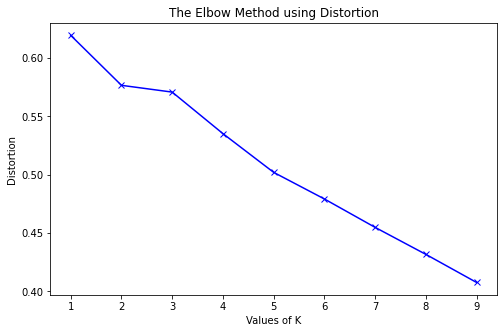

In [30]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(public_grouped_clustering)
    kmeanModel.fit(public_grouped_clustering)
 
    distortions.append(sum(np.min(cdist(public_grouped_clustering, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / public_grouped_clustering.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(public_grouped_clustering, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / public_grouped_clustering.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [47]:
# add clustering labels
public_cafe_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

public_merged = toronto_no_uni

#merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
public_merged = public_merged.join(public_cafe_sorted.set_index('PostalCode'), on='PostalCode')

public_merged.head() # check the last columns!
public_finale = public_merged.dropna()


ValueError: cannot insert Cluster Labels, already exists

In [32]:
public_finale.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Universities,Uni_score,Uni_population,Covid_cases,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,N/A,0,N/A,0.013383,1.0,Keefaa Coffee,Cup of coffee,Cuppa Coffee Studios,Arena Coffee Bar
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,N/A,0,N/A,N/A,1.0,Second Cup Coffee Co.,Second Cup Coffee Co. featuring Pinkberry Froz...,Timothy's World Coffee,NEO COFFEE BAR
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,N/A,0,N/A,0.004912,1.0,Nostalgia Coffee Co.,135 Ossington,Reunion Island Coffee,Piedmont Coffee Bar
10,M6B,North York,Glencairn,43.709577,-79.445073,N/A,0,N/A,0.01366,1.0,Sweet House Coffee,135 Ossington,RailRoad Coffee Co.,Pavillion Coffee
13,M3C,North York,Don Mills South,43.725900,-79.340923,N/A,0,N/A,0.017288,1.0,Pauls coffee shop,Reunion Island Coffee,Pavillion Coffee,Piedmont Coffee Bar


In [48]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, cases in zip(public_finale['Latitude'], public_finale['Longitude'],
                                         public_finale['PostalCode'], public_finale['Cluster Labels'],
                                         public_finale['Covid_cases']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=500*cases,
        #radius = 5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

AttributeError: 'dict' object has no attribute 'rgb2hex'

In [32]:
public_finale.loc[public_finale['Cluster Labels'] == 0, public_finale.columns[[1] + list(range(5, public_finale.shape[1]))]]



,Borough,Universities,Uni_score,Uni_population,Covid_cases,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
14,East York,N/A,0,N/A,0.013296,0.0,Coffee Time,Reunion Island Coffee,Pavillion Coffee,Piedmont Coffee Bar
31,West Toronto,N/A,0,N/A,0.014667,0.0,Coffee Time,Balzac’s Coffee,The Peoples Coffee Time,Mast Coffee
47,East Toronto,N/A,0,N/A,0.004947,0.0,unicorn coffee,Simple Coffee,Coffee time,Coffee Time
88,Etobicoke,N/A,0,N/A,0.012098,0.0,Coffee Time,Big Guy's Little Coffee Shop,Pauls coffee shop,Piedmont Coffee Bar
90,Scarborough,N/A,0,N/A,0.015986,0.0,Coffee Time,Coffee Here,Sam's Coffee Truck,Sam James Coffee Bar Oz


In [38]:
public_finale.loc[public_finale['Cluster Labels'] == 4, public_finale.columns[[1] + list(range(5, public_finale.shape[1]))]]


,Borough,Universities,Uni_score,Uni_population,Covid_cases,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
26,Scarborough,N/A,0,N/A,0.011317,4.0,Coffee Culture Cafe & Eatery,135 Ossington,Reunion Island Coffee,Piedmont Coffee Bar


## Data refinement
### Distance to Universities:
calculate the distance to the nearest university using the euclidean distance between two sets of geographical coordinates.
The population size of the university and the name are fed into the refined dataframe

In [39]:
def distance_to_uni(lat, lng, uni_df):
    dist = []
    for index, row in uni_df.iterrows():
        euclid = np.sqrt((row["Latitude"]-lat)**2 + (row["Longitude"]-lng)**2)
        dist.append([euclid, row["Universities"],row["Uni_population"] ])

    return min(dist)

In [35]:
distance_to_uni(2,2,toronto_with_uni)

[91.2851229009538, 'UofT', '12980']

In [40]:
public_finale["dist_to_uni"] = public_finale.apply(lambda x: distance_to_uni(x["Latitude"],x["Longitude"],toronto_with_uni)[0], axis=1)
public_finale["uni_population"] = public_finale.apply(lambda x: distance_to_uni(x["Latitude"],x["Longitude"],toronto_with_uni)[2], axis=1)

/anaconda3/envs/DataScience/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [41]:
public_finale["Covid_cases"].replace(to_replace={"N/A": "0.001"}, inplace=True)
public_finale["uni_population"].replace(to_replace={"93,081": "93000"}, inplace=True)
colors = {'0.0':'red', '1.0':'green', '2.0':'blue', '3.0':'yellow', '4.0':'orange', '5.0':'gray'}
pd.to_numeric(public_finale['Covid_cases'])

rng = np.random.RandomState(0)
x = pd.to_numeric(public_finale['Covid_cases'])
y = pd.to_numeric(public_finale['dist_to_uni'])
s_test = pd.to_numeric(public_finale['uni_population'])
d = y/s_test
c = public_finale['Cluster Labels']
#colors = {'North America':'red', 'Europe':'green', 'Asia':'blue', 'Australia':'yellow'}

#plt.scatter(x, y, s=100*df['population'], alpha=0.3,
#            c= df['continent'].map(colors),
#            cmap='viridis')
#plt.colorbar();  
public_finale
dist = public_cafes.groupby('PostalCode').mean()[["Venue distance"]]
count_public = public_cafes.groupby('PostalCode').count()[["Venue Category"]]

public_finale = public_finale.merge(dist, on=["PostalCode"])
public_finale = public_finale.merge(count_public, on=["PostalCode"])

/anaconda3/envs/DataScience/lib/python3.7/site-packages/pandas/core/generic.py:6610: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [42]:
public_finale.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Universities,Uni_score,Uni_population,Covid_cases,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,dist_to_uni,uni_population,Venue distance,Venue Category
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,N/A,0,N/A,0.013383,1.0,Keefaa Coffee,Cup of coffee,Cuppa Coffee Studios,Arena Coffee Bar,0.018530,39471,405.500000,11
1,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,N/A,0,N/A,0.001,1.0,Second Cup Coffee Co.,Second Cup Coffee Co. featuring Pinkberry Froz...,Timothy's World Coffee,NEO COFFEE BAR,0.010563,93000,414.352941,16
2,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,N/A,0,N/A,0.004912,1.0,Nostalgia Coffee Co.,135 Ossington,Reunion Island Coffee,Piedmont Coffee Bar,0.080884,97500,365.000000,1
3,M6B,North York,Glencairn,43.709577,-79.445073,N/A,0,N/A,0.01366,1.0,Sweet House Coffee,135 Ossington,RailRoad Coffee Co.,Pavillion Coffee,0.053955,32117,146.000000,1
4,M3C,North York,Don Mills South,43.725900,-79.340923,N/A,0,N/A,0.017288,1.0,Pauls coffee shop,Reunion Island Coffee,Pavillion Coffee,Piedmont Coffee Bar,0.052918,97500,493.000000,1


## Results

Plotting the results which comprise of two scatter plots using the data refined in the data refined stage. 
A regression analysis was applied onto one of the two datasets to inspect for any trends

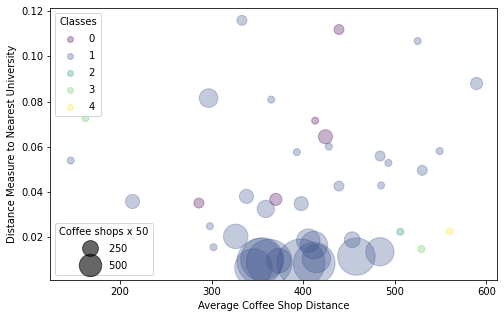

In [44]:
fig, ax = plt.subplots()

scatter = ax.scatter(pd.to_numeric(public_finale['Venue distance']), y, 
            s=50*pd.to_numeric(public_finale['Venue Category']), alpha=0.3,
            c= public_finale['Cluster Labels'],
            cmap='viridis')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)
ax.set_xlabel("Average Coffee Shop Distance")
ax.set_ylabel("Distance Measure to Nearest University")
# produce a legend with a cross section of sizes from the scatter
#handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
#legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels[:2], loc="lower left", title="Coffee shops x 50")
plt.show()
fig.savefig('sep_case.pdf')

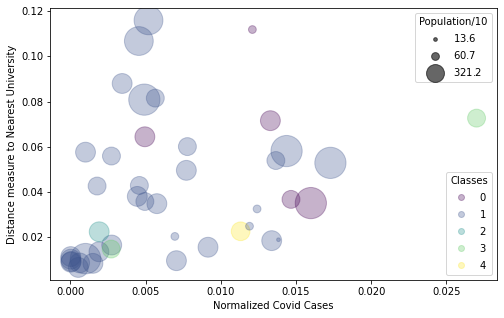

In [40]:
fig, ax = plt.subplots()

scatter = ax.scatter(x, y, s=.01*s_test, alpha=0.3,
            c= public_finale['Cluster Labels'],
            cmap='viridis')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Classes")
ax.add_artist(legend1)
ax.set_xlabel("Normalized Covid Cases")
ax.set_ylabel("Distance measure to Nearest University")

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels[:3], loc="upper right", title="Population/10", bbox_to_anchor=(1.0, 1.0))
#labels[:3]
plt.show()
fig.savefig('dist_case.pdf')

In [55]:
#fig, ax = plt.subplots()

from scipy import stats
slope, intercept, r_value, pv, se = stats.linregress(pd.to_numeric(public_finale['Covid_cases']), 
                                                     pd.to_numeric(public_finale['dist_to_uni']))
print(pv)

ax = sns.regplot(x="Covid_cases", y="dist_to_uni", data=public_finale, line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})
ax.set_xlabel("Normalized Covid Cases")
ax.set_ylabel("Distance measure to Nearest University")
ax.set_title("Regression Analysis of Toronto Neighbourhoods")
plt.legend()
fig.savefig('regression.pdf')

0.06297043050190164
